In [1]:

!pip install pennylane
!pip install autograd
!pip install qiskit
!pip install pip install pennylane-qiskit

In [2]:
!pip install qutip

In [3]:
import pennylane as qml    
from pennylane import numpy as np                           
import matplotlib.pyplot as plt
import qutip as qp
import scipy as sp

from qiskit.visualization import plot_bloch_vector
%matplotlib inline

In [4]:
class SPSA:
    
    def __init__( self, a=3 , c=0.01, A=0, α=0.602 , γ=0.101):
        self._a = a
        self._c = c
        self._A = A
        self._α = α
        self._γ = γ
        
    def step( self, function, θ, k ):
        
        ak = self._a/(k+self._A+1)**self._α, 
        ck = self._c/(k+1)**self._γ
                
        Δ  = 2*np.round( np.random.rand(θ.size).reshape(θ.shape) )-1
        
        θ_plus  = θ + ck*Δ
        θ_minus = θ - ck*Δ   
        
        function_plus  = function( θ_plus )  
        function_minus = function( θ_minus )  
        
        ghat = np.divide( function_plus-function_minus, 2*ck*Δ + 1e-8 )
        
        return θ - ak*ghat 

In [5]:
num_qubits = 1
opt = SPSA( a=2, c=0.1 )
max_iterations = 500
#np.random.seed(129464)

In [6]:
dev_an = qml.device("default.qubit", wires=num_qubits, analytic=True)
dev_st = qml.device("default.qubit", wires=num_qubits, analytic=False, shots = 1e6)

In [7]:
def Initial_State(n_wires):
#    qml.Hadamard( wires = range(n_wires))
    qml.PauliX(wires = range(n_wires))
#    qml.T(wires = range(n_wires))

### 1. Local variational form

In [8]:
def Variational_circuit(params, n_wires):
    qml.broadcast( qml.Rot, wires= range(n_wires), pattern="single", parameters = params ) 

In [9]:
# Pauli Matrices

Paulis = np.zeros((3, 2, 2), dtype=complex)
Paulis[0] = [[0, 1], [1, 0]]
Paulis[1] = [[0, -1j], [1j, 0]]
Paulis[2] = [[1, 0], [0, -1]]

# Crear vector de Bloch a partir de los valores de expectacion

def BlochVec(n_wires, params):
    bloch_vector = []
    for k in range(3):
        bloch_k = PauliExp(n_wires, params, A=Paulis[k])
        bloch_k = bloch_k.numpy()
        bloch_vector.append(bloch_k)
    return bloch_vector

In [10]:
@qml.qnode(dev_an)
def Fidelity_analytic(params):
    n_wires = dev_an.num_wires
    Initial_State(n_wires)
    Variational_circuit(params, n_wires)
    return qml.probs(wires= range(n_wires))

# Calcular valores de expectacion

@qml.qnode(dev_an)
def PauliExp(n_wires, params, A=None):
    Variational_circuit(params, n_wires)
    # returns the expectation of the input matrix A
    return qml.expval(qml.Hermitian(A, wires = range(n_wires)))


@qml.qnode(dev_st)
def Fidelity_stochastic(params):
    n_wires = dev_st.num_wires
    Initial_State(n_wires)
    Variational_circuit(params, n_wires)
    return qml.probs(wires=range(n_wires))

In [11]:
infids_an = []
infids_st = []
params_list = []
#params = np.random.normal(0, np.pi, (num_qubits, 3))
params = 0.000001*np.ones((num_qubits, 3))
fun_an    = lambda params : 1 - Fidelity_analytic(params)[0]
fun_st    = lambda params : 1 - Fidelity_stochastic(params)[0]

In [12]:
for n in range(max_iterations):
    params_list.append(params)
    params = opt.step( fun_st, params, n )
    infids_an.append( fun_an(params) )
    infids_st.append( fun_st(params) )

print()
print( 'Final fidelidad = ', 1-infids_an[-1] )
print()

infids_an = np.array(infids_an)
infids_st = np.array(infids_st)


Final fidelidad =  0.999999999107096



In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Guardar Datos

import pickle

# Pickling

#with open("infids_an.txt", "wb") as fp:
#    pickle.dump(infids_an, fp)
#with open("infids_st.txt", "wb") as fp:
#    pickle.dump(infids_st, fp)
#with open("params_list.txt", "wb") as fp:
#    pickle.dump(params_list, fp)

    
    
# Unpickling
    

#with open("infids_an.txt", "rb") as fp:
#    infids_an = pickle.load(fp)
#with open("infids_st.txt", "rb") as fp:
#    infids_st = pickle.load(fp)
#with open("params_list.txt", "rb") as fp:
#    params_list = pickle.load(fp)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(0, 0.5, 'Infidelity')

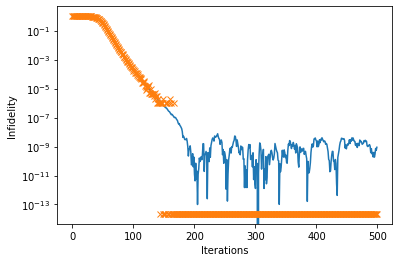

In [15]:
plt.plot( infids_an )
plt.yscale('log')
ylim = min( 0.01, plt.axis()[2] )
infids_st[infids_st<ylim] = ylim
plt.plot( infids_st , 'x')
plt.xlabel('Iterations')
plt.ylabel('Infidelity')

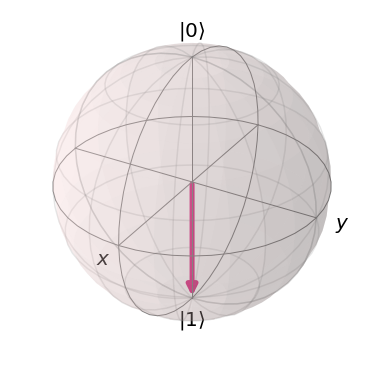

In [16]:
@qml.qnode(dev_an)
def PauliExp2(n_wires, A=None):
    Initial_State(n_wires)
    return qml.expval(qml.Hermitian(A, wires = range(n_wires)))

def BlochVec2(n_wires):
    bloch_vector = []
    for k in range(3):
        bloch_k = PauliExp2(n_wires, A=Paulis[k])
        bloch_k = bloch_k.numpy()
        bloch_vector.append(bloch_k)
    return bloch_vector

plot_bloch_vector(BlochVec2(num_qubits))

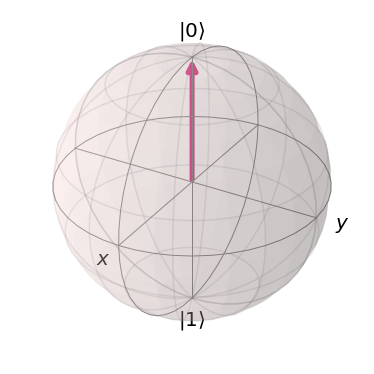

In [17]:
plot_bloch_vector(BlochVec(num_qubits, params_list[0]))

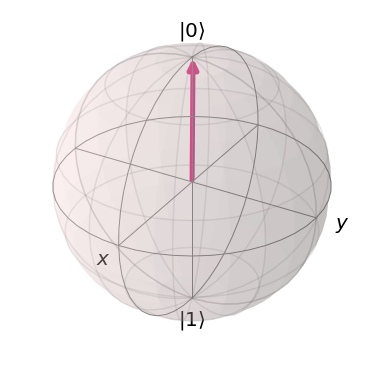

In [18]:
plot_bloch_vector(BlochVec(num_qubits, params_list[10]))

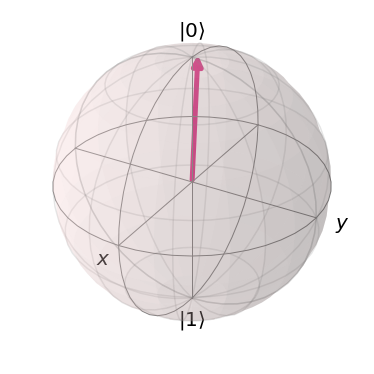

In [19]:
plot_bloch_vector(BlochVec(num_qubits, params_list[20]))

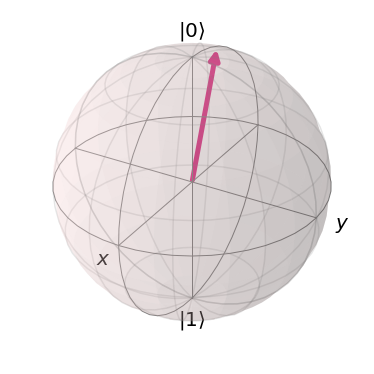

In [20]:
plot_bloch_vector(BlochVec(num_qubits, params_list[30]))

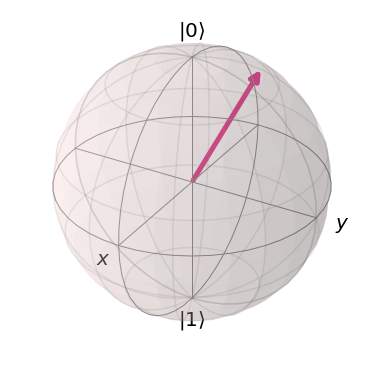

In [21]:
plot_bloch_vector(BlochVec(num_qubits, params_list[40]))

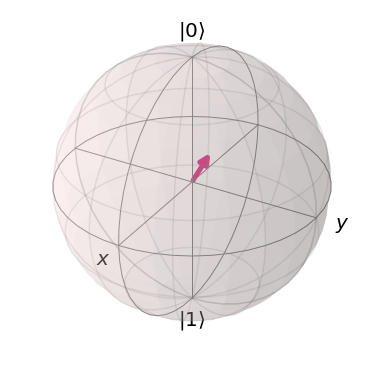

In [22]:
plot_bloch_vector(BlochVec(num_qubits, params_list[50]))

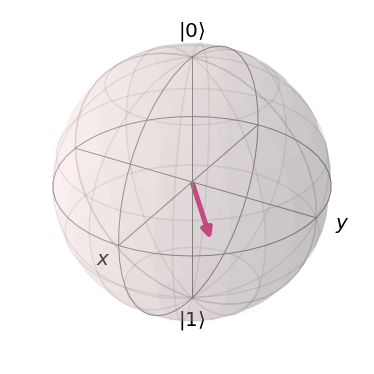

In [23]:
plot_bloch_vector(BlochVec(num_qubits, params_list[60]))

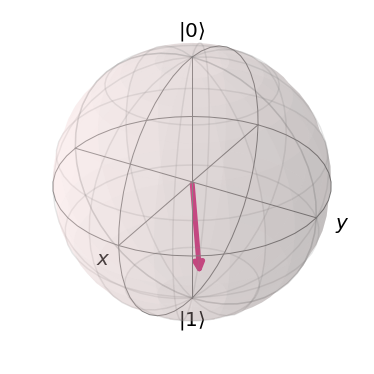

In [24]:
plot_bloch_vector(BlochVec(num_qubits, params_list[70]))

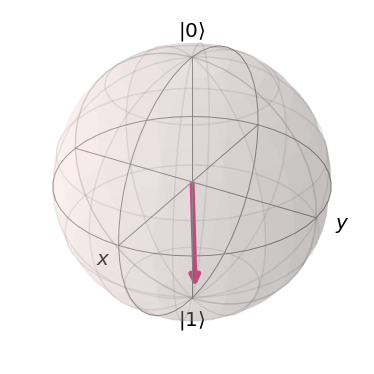

In [25]:
plot_bloch_vector(BlochVec(num_qubits, params_list[80]))

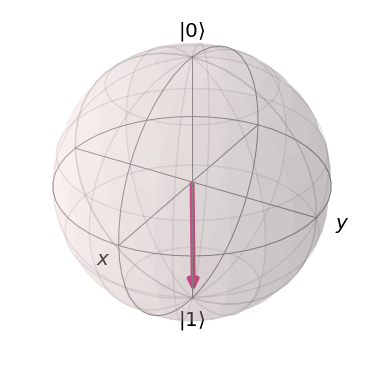

In [26]:
plot_bloch_vector(BlochVec(num_qubits, params_list[90]))

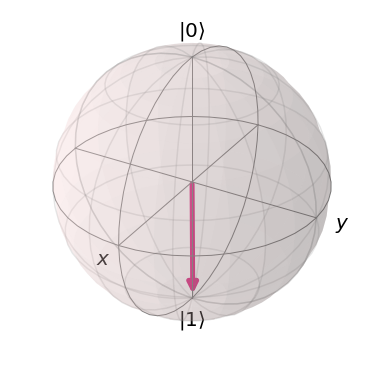

In [27]:
plot_bloch_vector(BlochVec(num_qubits, params_list[100]))

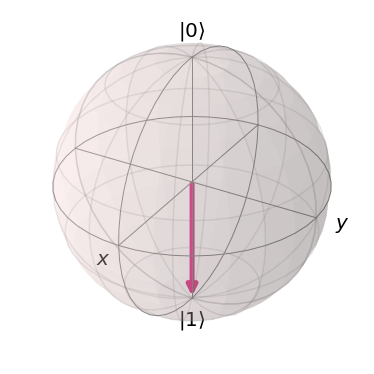

In [28]:
plot_bloch_vector(BlochVec(num_qubits, params_list[200]))

In [29]:
Vec_List = []

for i in range(len(params_list)):
  b_vec = BlochVec(num_qubits, params_list[i])
  Vec_List.append(b_vec)

In [30]:
x_vec = []
y_vec = []
z_vec = []

for i in range(len(Vec_List)):
  x = Vec_List[i][0]
  y = Vec_List[i][1]
  z = Vec_List[i][2]
  x_vec.append(x)
  y_vec.append(y)
  z_vec.append(z)

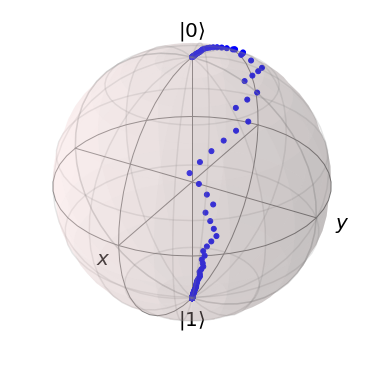

In [31]:
b1 = qp.Bloch()
b1.add_points([x_vec, y_vec, z_vec])
b1.show()

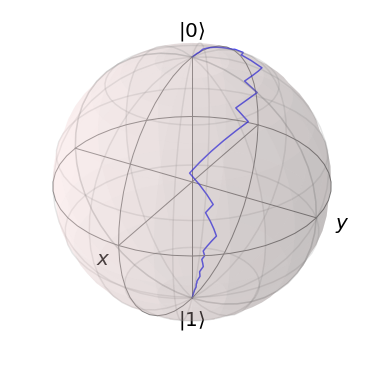

In [32]:
b2 = qp.Bloch()
b2.add_points([x_vec, y_vec, z_vec], meth='l')
b2.show()

In [33]:
from google.colab import files

b1.save(name='b1.png')
files.download('b1.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
b2.save(name='b2.png')
files.download('b2.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>